# Mobile Color Family

In this notebook, I will attempt to use the product images to determine the color of each mobile device. 

## Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, GlobalAveragePooling2D
from keras.utils import np_utils

from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

%matplotlib inline
pd.options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading the data sets

In [3]:
# mobile = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/mobile_data_info_train_competition.csv')
# tags = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/tags.csv')
mobile = pd.read_csv('mobile_data_info_train_competition.csv')
tags = pd.read_csv('tags.csv')

In [4]:
mobile_color = mobile[['itemid', 'image_path', 'Color Family']]
mobile_color.head()

,itemid,image_path,Color Family
0,2346660,mobile_image/a9c8f0fdd6587deed197634066cf7eee.jpg,12.0
1,2816338,mobile_image/3b9a11608551b11b9330268e0d055e01.jpg,12.0
2,2847602,mobile_image/1d719e936841a83c165da620f927de68.jpg,12.0
3,3116949,mobile_image/1d35a74d90df6cf4a02e6a5df9e9ff29.jpg,12.0
4,3794648,mobile_image/5556577b09539a9c0db0d00e0f171e2d.jpg,NaN


In [5]:
mobile_color.isnull().sum()

itemid              0
image_path          0
Color Family    75499
dtype: int64

In [6]:
tags_color = tags[['color', 'color_val']].dropna()
tags_color

,color,color_val
0,blue,4.0
1,gold,0.0
2,brown,14.0
3,navy blue,15.0
4,yellow,1.0
5,neutral,16.0
6,rose gold,17.0
7,light blue,3.0
8,dark grey,18.0
9,silver,19.0


## More EDA and Cleaning

In [7]:
mobile_color_filled = mobile_color.dropna()

In [8]:
mobile_color_filled['Color Family'].value_counts()

10.0    37350
0.0     17162
12.0     7883
13.0     6999
19.0     5596
4.0      3917
20.0     2359
6.0       848
2.0       671
25.0      594
7.0       384
14.0      373
1.0       327
11.0      196
18.0       79
16.0       63
17.0       23
22.0        4
3.0         1
24.0        1
23.0        1
Name: Color Family, dtype: int64

In [9]:
# putting the value counts into a dataframe
mobile_value_counts = {k:mobile_color_filled['Color Family'].value_counts()[k] for k in mobile_color_filled['Color Family'].value_counts().keys()}
mobile_value_counts = pd.DataFrame(mobile_value_counts.items()).rename(columns = {0:'color_val', 1:"frequency"})
mobile_value_counts.head()

,color_val,frequency
0,10.0,37350
1,0.0,17162
2,12.0,7883
3,13.0,6999
4,19.0,5596


In [10]:
# merging with the colors
mobile_value_counts = mobile_value_counts.merge(tags_color, on="color_val" )
mobile_value_counts.head()

,color_val,frequency,color
0,10.0,37350,black
1,0.0,17162,gold
2,12.0,7883,white
3,13.0,6999,red
4,19.0,5596,silver


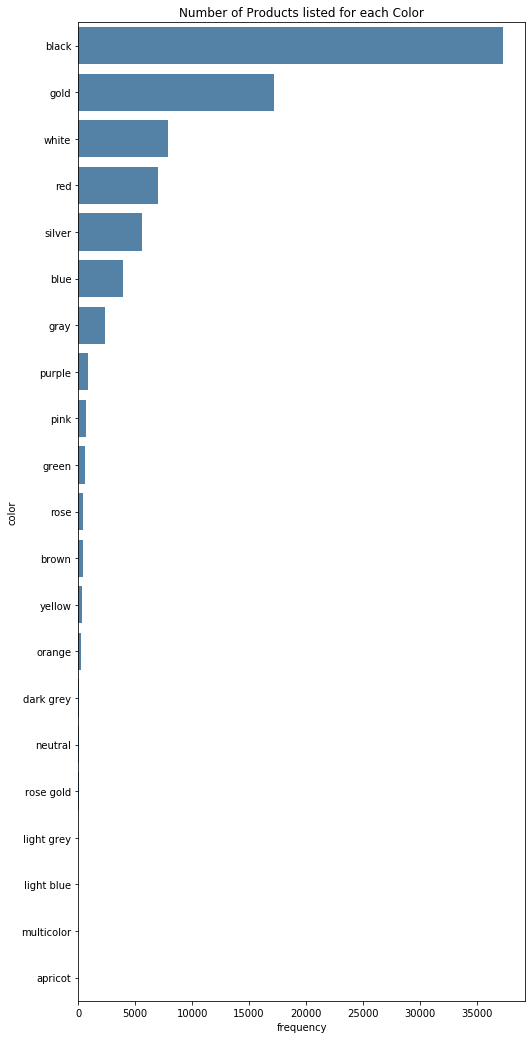

In [11]:
# visualizing the spread of the data
plt.figure(figsize=(8, 18))
ax_hist = plt.axes()
ax_hist.set_title(label ="Number of Products listed for each Color")
sns.barplot(x='frequency', y='color', data=mobile_value_counts, orient='h', color='steelblue')

From the histogram alone, we see that there are 7 main colours which the products belong to. I will be classifying the rest under 'others' for a total of 8 different classes for the model. 

## Feature Engineering

In [12]:
# summing up others
mobile_value_counts['frequency'][7:].sum()

3565

In [13]:
# extracting the top 7 colors
mobile_value_counts = mobile_value_counts.head(7)
mobile_value_counts

,color_val,frequency,color
0,10.0,37350,black
1,0.0,17162,gold
2,12.0,7883,white
3,13.0,6999,red
4,19.0,5596,silver
5,4.0,3917,blue
6,20.0,2359,gray


In [14]:
# extracting the color_val
mobile_top7 = {mobile_value_counts.at[i, "color_val"]:i for i in mobile_value_counts.index}
mobile_top7[100.0] = 7
mobile_top8 = mobile_top7
print(mobile_top8)

{10.0: 0, 0.0: 1, 12.0: 2, 13.0: 3, 19.0: 4, 4.0: 5, 20.0: 6, 100.0: 7}


In [15]:
# assiging the 8th class 'others'
mobile_value_counts.loc[8] = [100, 3565, 'others']

In [16]:
mobile_color_filled

,itemid,image_path,Color Family
0,2346660,mobile_image/a9c8f0fdd6587deed197634066cf7eee.jpg,12.0
1,2816338,mobile_image/3b9a11608551b11b9330268e0d055e01.jpg,12.0
2,2847602,mobile_image/1d719e936841a83c165da620f927de68.jpg,12.0
3,3116949,mobile_image/1d35a74d90df6cf4a02e6a5df9e9ff29.jpg,12.0
6,5769008,mobile_image/e088ca5ebb1ab5ba90a8cff8f9c4f791.jpg,10.0
...,...,...,...
160323,1510035980,mobile_image/4bd23a85f190ca5d416904a709274b1e.jpg,13.0
160325,1510771637,mobile_image/70e0d8ddd69692b0f134498efbddf4e1.jpg,10.0
160326,1515822742,mobile_image/d58393fe029ba62160d2a5d1fa6638a1.jpg,10.0
160327,1516747666,mobile_image/bfacb3c9af2f6a597008e57fb2d34609.jpg,10.0


In [17]:
mobile_color_filled.rename(columns={'Color Family':'color_val'}, inplace=True)
mobile_color_filled['new_color_val'] = mobile_color_filled['color_val'].apply(lambda x : x if x in mobile_top8.keys() else 100)
mobile_color_filled.head()

,itemid,image_path,color_val,new_color_val
0,2346660,mobile_image/a9c8f0fdd6587deed197634066cf7eee.jpg,12.0,12.0
1,2816338,mobile_image/3b9a11608551b11b9330268e0d055e01.jpg,12.0,12.0
2,2847602,mobile_image/1d719e936841a83c165da620f927de68.jpg,12.0,12.0
3,3116949,mobile_image/1d35a74d90df6cf4a02e6a5df9e9ff29.jpg,12.0,12.0
6,5769008,mobile_image/e088ca5ebb1ab5ba90a8cff8f9c4f791.jpg,10.0,10.0


In [18]:
# reassigning the color values
mobile_color_filled['new_color_val'] = mobile_color_filled['new_color_val'].map(mobile_top8)

In [19]:
# verifying the change
mobile_color_filled['new_color_val'].value_counts()

0    37350
1    17162
2     7883
3     6999
4     5596
5     3917
7     3565
6     2359
Name: new_color_val, dtype: int64

I will be using a sample of the images (20000) to train the model for color classification.

In [20]:
# checking the spread of the sample
mobile_color_filled.sample(20000, random_state=42)['new_color_val'].value_counts()

0    8879
1    3936
2    1918
3    1635
4    1323
5     933
7     853
6     523
Name: new_color_val, dtype: int64

In [21]:
mobile_color_filled_sample = mobile_color_filled.sample(20000, random_state=42)
mobile_color_filled_sample = mobile_color_filled_sample[['itemid', 'image_path', 'new_color_val']]
mobile_color_filled_sample

,itemid,image_path,new_color_val
81169,130210286,mobile_image/5d67fea085b0245017628ffaaaa69540.jpg,2
146137,1409643243,mobile_image/4c8a119145b1dff426e34d9dd96bf096.jpg,6
69161,28210135,mobile_image/88c16e22a817ff738114e66203f0ef21.jpg,6
40555,989045608,mobile_image/ad899f2641693e3524fab59252b37029.jpg,1
142503,1847080890,mobile_image/40727fe4d654c9156edaf85243b765b5.jpg,0
...,...,...,...
28162,720786312,mobile_image/dfd529f88b45d595c167ee94913a6898.jpg,3
5901,1626144320,mobile_image/acce0c60f3e6f38e8194af0ef2b22573.jpg,1
117765,745300770,mobile_image/177726f9e51e1f888f48f3c374219905.jpg,1
1398,937985922,mobile_image/c4944f775553cb7d410b1e441d350faa.jpg,0


## Preprocessing

We will be doing train test split on our known data (mobile_color_filled) to train our model.

In [22]:
X = [load_img(i, target_size=(224, 224)) for i in mobile_color_filled_sample['image_path']]
X = [img_to_array(i) for i in X]
X = [i.reshape(( i.shape[0], i.shape[1], i.shape[2])) for i in X]
X = np.array([preprocess_input(i) for i in X])

y = np_utils.to_categorical(np.array(mobile_color_filled_sample['new_color_val']))

In [23]:
X.shape

(20000, 224, 224, 3)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [25]:
X_train.shape

(15000, 224, 224, 3)

In [26]:
X_train[0]

array([[[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       ...,

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22

In [27]:
X_test[0]

array([[[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       ...,

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22

## Modelling

### VGG16

I will be using the VGG16 model to do transfer learning for the classification problem. This is due to the high performance of the VGG16 model and the fact that it is easily accessible. 

In [28]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(224, 224, 3))

In [29]:
# freezing the training layers
for layer in model.layers:
    layer.trainable = False

In [30]:
# add new classifier layers
flat1 = GlobalAveragePooling2D()(model.output)
# class1 = Dense(128, activation='relu')(flat1)
output = Dense(8, activation='softmax')(flat1)
# define new model
model = Model(inputs=model.inputs, outputs=output)

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [32]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
history = model.fit(X_train,
                    y_train, 
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    verbose=1)

Train on 15000 samples, validate on 5000 samples
Epoch 1/10
15000/15000 [==============================] - 3040s 203ms/step - loss: 4.6317 - accuracy: 0.2871 - val_loss: 3.3489 - val_accuracy: 0.3370
Epoch 2/10
15000/15000 [==============================] - 1207s 80ms/step - loss: 2.8446 - accuracy: 0.3869 - val_loss: 2.6471 - val_accuracy: 0.3946
Epoch 3/10
15000/15000 [==============================] - 1202s 80ms/step - loss: 2.3156 - accuracy: 0.4231 - val_loss: 2.3163 - val_accuracy: 0.4010
Epoch 4/10
15000/15000 [==============================] - 1524s 102ms/step - loss: 2.0176 - accuracy: 0.4543 - val_loss: 2.0945 - val_accuracy: 0.4538
Epoch 5/10
15000/15000 [==============================] - 1231s 82ms/step - loss: 1.8228 - accuracy: 0.4747 - val_loss: 1.9324 - val_accuracy: 0.4600
Epoch 6/10
15000/15000 [==============================] - 1256s 84ms/step - loss: 1.6783 - accuracy: 0.4923 - val_loss: 1.8451 - val_accuracy: 0.4628
Epoch 7/10
15000/15000 [=========================

In [34]:
# # Check out our train loss and test loss over epochs.
# train_loss = history.history['loss']
# test_loss = history.history['val_loss']

# # Set figure size.
# plt.figure(figsize=(12, 8))

# # Generate line plot of training, testing loss over epochs.
# plt.plot(train_loss, label='Training Loss', color='#185fad')
# plt.plot(test_loss, label='Testing Loss', color='orange')

# # Set title
# plt.title('Training and Testing Loss by Epoch', fontsize = 18)
# plt.xlabel('Epoch', fontsize = 18)
# plt.ylabel('Categorical Crossentropy', fontsize = 18)
# plt.xticks([i for i in range(51)], [i for i in range(51)])

# plt.legend(fontsize = 18);

In [35]:
# Evaluate model on test data.
score = model.evaluate(X_test,
                       y_test,
                       verbose=1)

labels = model.metrics_names

5000/5000 [==============================] - 9367s 2s/step


In [36]:
# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

loss: 1.6058678037643432
accuracy: 0.49459999799728394


In [2]:
predictions = model.predict_on_batch(X_test)

NameError: name 'model' is not defined

In [ ]:
predictions[0]

In [ ]:
predictions[50].argmax(axis=-1)

In [ ]:
preds = []
for i in predictions:
    preds.append(i.argmax(axis = -1))


In [ ]:
len(preds)